In [352]:
# Jobs Data
# (TaskID, MachineID, Duration, Energy Rate(kwh))
jobs_data = {
    "Job1": [("A", 3, 2, 35), ("B", 2, 2, 20), ("C", 1, 3, 25)],
    "Job2": [("D", 1, 2, 27), ("E", 2, 2, 32), ("F", 3, 3, 37)],
    "Job3": [("G", 2, 2, 19), ("H", 3, 2, 36), ("I", 1, 3, 28)]
}

num_machines = 3


In [353]:
import pygad
import pandas as pd
import csv
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [354]:
#Future predicted PV power output from the predictive model 

predicted_PV_output_list = []

with open ("future_PV_power_predictions.csv", "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader) #Skip heading row
    
    for row in csv_reader:
        predicted_PV_output_list.append(float(row[1]) / 1000)

print("Predicted PV Power Output (kw):", predicted_PV_output_list)

# PV generation for the date specified in the predictive model
pv_generation = predicted_PV_output_list


# Time-of-Use (TOU) electricity tariffs for a 24-hour period
tou_rates = [0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20]

Predicted PV Power Output (kw): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9203195305360237, 5.952031288590395, 11.911244860812074, 18.833412950565652, 23.260055466108234, 24.810894072916806, 27.691351847891923, 26.460897382407243, 21.88071034511023, 16.28448753302781, 7.657632964638227, 0.9170140915040471, 0.0, 0.0, 0.0, 0.0, 0.0]


In [355]:
# Flatten the list of tasks and extract the unique task IDs
all_tasks = [task[0] for job in jobs_data.values() for task in job]

# Create a mapping of tasks to integers and vice versa
task_to_int = {task: i for i, task in enumerate(all_tasks)}
int_to_task = {i: task for task, i in task_to_int.items()}

# Create a mapping of each task to its job
task_to_job = {}
for job, tasks in jobs_data.items():
    for task in tasks:
        task_id = task[0]
        task_to_job[task_id] = job

# Printing out the mappings to verify
print("Task to Integer Mapping:", task_to_int)
print("Integer to Task Mapping:", int_to_task)
print("Task to Job Mapping:", task_to_job)
# task_to_int is used to convert task IDs to integers for gene_space and for num_genes


# Create a dictionary with the sequence of tasks within each job
job_sequences = {job_id: [task[0] for task in tasks] for job_id, tasks in jobs_data.items()}
print(f"Sequence of tasks in each job: {job_sequences}")

Task to Integer Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8}
Integer to Task Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I'}
Task to Job Mapping: {'A': 'Job1', 'B': 'Job1', 'C': 'Job1', 'D': 'Job2', 'E': 'Job2', 'F': 'Job2', 'G': 'Job3', 'H': 'Job3', 'I': 'Job3'}
Sequence of tasks in each job: {'Job1': ['A', 'B', 'C'], 'Job2': ['D', 'E', 'F'], 'Job3': ['G', 'H', 'I']}


In [356]:
# Generate a diverse initial population of solutions that abide by job-shop scheduling constraints
def generate_diverse_population(sol_per_pop, job_sequences, task_to_int):
    initial_population = []
    for _ in range(sol_per_pop):
        
        # Create a copy of job_sequences that will be modified. 
        working_sequences = {job: list(seq) for job, seq in job_sequences.items()}
        solution = []
        
        # While there are tasks left to be scheduled
        while any(working_sequences.values()):
            
            # Finds jobs which still have tasks left to schedule
            available_jobs = [job for job, seq in working_sequences.items() if seq]
            
            # Select a random job from the available jobs
            chosen_job = random.choice(available_jobs)
            
            # Remove the first task from the chosen job in working sequences
            next_task = working_sequences[chosen_job].pop(0)
            
            # Convert the task ID to its integer representation before appending
            solution.append(task_to_int[next_task])
            
        initial_population.append(solution)
    return initial_population

In [357]:
# Now create the initial population using the updated function
sol_per_pop = 100 # Number of solutions per population
initial_population = generate_diverse_population(sol_per_pop, job_sequences, task_to_int)

# Print the first 5 solutions to check their diversity
for i, solution in enumerate(initial_population[:5]):
    print(f"Solution {i+1}: {solution}")

Solution 1: [6, 3, 0, 4, 1, 2, 7, 5, 8]
Solution 2: [6, 7, 8, 3, 0, 4, 1, 2, 5]
Solution 3: [0, 1, 6, 3, 7, 8, 2, 4, 5]
Solution 4: [6, 0, 7, 3, 8, 4, 5, 1, 2]
Solution 5: [3, 0, 4, 6, 5, 1, 2, 7, 8]


In [358]:
# Create a custom crossover function that respects the job-shop scheduling constraints
def custom_crossover_function(parents, offspring_size, ga_instance):
    offspring = np.empty(offspring_size)
    
    # Offspring_size is a tuple of offspring size and number of genes
    
    # Access global variables directly since they are not part of ga_instance
    global job_sequences, task_to_int, int_to_task, task_to_job
    
    for k in range(offspring_size[0]):
        # Choosing two parents randomly
        parent1_idx, parent2_idx = np.random.choice(len(parents), 2, replace=False)
        parent1, parent2 = parents[parent1_idx], parents[parent2_idx]

        # Random crossover point
        crossover_point = np.random.randint(0, offspring_size[1])
        
        # First part of offspring from parent 1
        offspring[k, :crossover_point] = parent1[:crossover_point]
        
        # Remaining tasks from parent 2
        offspring_remaining_tasks = [task for task in parent2 if task not in offspring[k, :crossover_point]]
        
        # Fill in the rest of the offspring with tasks from the second parent that maintain job sequence
        fill_index = crossover_point
        for job, tasks in job_sequences.items():
            for task in tasks:
                task_int = task_to_int[task]
                if task_int in offspring_remaining_tasks:
                    offspring[k, fill_index] = task_int
                    fill_index += 1

    # Ensure the offspring contains only integers
    offspring = np.asarray(offspring, dtype=int)
    
    return offspring

In [359]:
# Create a mutation function that respects the job-shop scheduling constraints
def custom_mutation_function(offspring, ga_instance):
    
    # Define an appropriate mutation rate 
    mutation_rate = 0.07
    num_genes = ga_instance.num_genes
    
    # Offspring is an array with rows of solutions, each element is a gene(task)
    # Loop through each solution
    for idx in range(offspring.shape[0]):
        
        # Apply mutations based on the mutation rate
        # Loop through each gene in the solution
        for gene_idx in range(num_genes):
            
            if np.random.random() < mutation_rate:
                
                # Identify the job of the current task
                current_task = int_to_task[offspring[idx, gene_idx]]
                current_job = task_to_job[current_task]

                # Get a list of tasks that are not in the current job. Do not want to swap tasks in the same job
                not_current_job_tasks = [task_to_int[task] for task in all_tasks if task_to_job[task] != current_job]

                # Choose a task from a different job to swap with
                if not_current_job_tasks:  # Ensure there are tasks to swap with
                    task_to_swap_with = np.random.choice(not_current_job_tasks)
                    
                    # Find the index of the task to swap with
                    task_swap_idx = np.where(offspring[idx] == task_to_swap_with)[0][0]

                    # Swap the two tasks
                    offspring[idx, gene_idx], offspring[idx, task_swap_idx] = \
                        offspring[idx, task_swap_idx], offspring[idx, gene_idx]
    return offspring

In [360]:
#pv_utilized_per_hour = []
#def calculate_task_timings_and_pv(solution, jobs_data, pv_generation):
def calculate_task_timings(solution, jobs_data):
    machine_next_available_time = {i+1: 0 for i in range(num_machines)}  # Machine availability time
    job_last_task_end_time = {job: 0 for job in jobs_data}  # Last task end time for each job
    tasks_in_hour = {hour: [] for hour in range(24)}  # Tasks in each hour

    task_timings = []

    for task_int in solution:
        task_id = int_to_task[task_int]
        job = task_to_job[task_id]
        _, machine_id, duration, energy_rate = next((task for task in jobs_data[job] if task[0] == task_id), (None, None, None, None))
        if None in (_, machine_id, duration, energy_rate):
            continue  # Skip if any detail is missing

        earliest_start_time = max(machine_next_available_time[machine_id], job_last_task_end_time[job])
        end_time = earliest_start_time + duration

        # Add the task to tasks_in_hour for each hour it occupies
        for hour in range(duration):
            hour_index = (earliest_start_time + hour) % 24
            tasks_in_hour[hour_index].append((task_id, energy_rate))

        task_timings.append((task_id, machine_id, earliest_start_time, end_time)) 

        machine_next_available_time[machine_id] = end_time
        job_last_task_end_time[job] = end_time
    return task_timings




In [361]:
# Before calling calculate_grid_and_pv_power_per_hour, make sure tasks_start_end_times is in the correct format
tasks_start_end_times = calculate_task_timings(solution, jobs_data)
print(tasks_start_end_times)

[('D', 1, 0, 2), ('A', 3, 0, 2), ('E', 2, 2, 4), ('G', 2, 4, 6), ('F', 3, 4, 7), ('B', 2, 6, 8), ('C', 1, 8, 11), ('H', 3, 7, 9), ('I', 1, 11, 14)]


In [362]:


def calculate_grid_and_pv_power_per_hour(jobs_data, pv_generation, tasks_start_end_times):
    grid_power_needed_per_hour = [0] * 24
    pv_utilized_per_hour = [0] * 24  # Initialize both lists with zeros for each hour

    tasks_in_hour = {hour: [] for hour in range(24)}  # Tasks processed each hour

    for task_id, machine_id, start_time, end_time in tasks_start_end_times:  # Removed the unpacking of _
        for hour in range(start_time, end_time):
            hour_mod = hour % 24
            for task in jobs_data[task_to_job[task_id]]:
                if task[0] == task_id:
                    energy_rate = task[3]
                    break
            tasks_in_hour[hour_mod].append((task_id, energy_rate))

    for hour, tasks in tasks_in_hour.items():
        total_energy_required = sum(task[1] for task in tasks)
        pv_power_available = pv_generation[hour]

        if total_energy_required <= pv_power_available:
            # All tasks can be fully powered by PV
            pv_utilized_per_hour[hour] = total_energy_required
            # No grid power is needed, but we track PV utilization
        else:
            # Tasks need more energy than available from PV
            excess_energy_required = total_energy_required - pv_power_available
            pv_utilized_per_hour[hour] = pv_power_available  # Utilize all available PV power
            grid_power_needed_per_hour[hour] = excess_energy_required  # The remainder comes from the grid

    return grid_power_needed_per_hour, pv_utilized_per_hour



In [363]:
# Define a fitness function that uses total electricity cost of solution to determine the solutions fitness

def fitness_func(ga_instance, solution, solution_idx):
    # Initialize the necessary variables
    machine_next_available_time = [0] * num_machines
    job_last_task_end_time = {job: 0 for job in jobs_data}
    last_processed_task_index = {job: -1 for job in jobs_data}
    max_end_time = 0
    valid_solution = True
    total_cost = 0
    
    # This will hold the start and end time for each task to calculate grid power needed later
    tasks_start_end_times = []

    for task_int in solution:
        task_id = int_to_task[task_int]
        job = task_to_job[task_id]
        _, machine_id, duration, energy_rate = next((task for task in jobs_data[job] if task[0] == task_id), (None, None, None, None))
        
        if None in (_, machine_id, duration, energy_rate):
            valid_solution = False
            break

        # Ensure tasks are in the correct order within each job
        current_task_index = jobs_data[job].index((task_id, machine_id, duration, energy_rate))
        if current_task_index <= last_processed_task_index[job]:
            valid_solution = False
            break
        last_processed_task_index[job] = current_task_index

        machine_id -= 1  # Adjust to 0-based indexing
        earliest_start_time = max(machine_next_available_time[machine_id], job_last_task_end_time[job])
        end_time = earliest_start_time + duration
        max_end_time = max(max_end_time, end_time)

        # Save task timings for grid power calculation
        tasks_start_end_times.append((task_id, machine_id, earliest_start_time, end_time))

        machine_next_available_time[machine_id] = end_time
        job_last_task_end_time[job] = end_time
    
    # Calculate grid power needed for each hour considering all tasks and available PV power
    if valid_solution and max_end_time <= 24:
        
        # Use tasks_start_end_times saved earlier in fitness function
        grid_power_needed_per_hour, pv_utilized_per_hour = calculate_grid_and_pv_power_per_hour(jobs_data, pv_generation, tasks_start_end_times)
        for hour in range(24):
            total_cost += grid_power_needed_per_hour[hour] * tou_rates[hour]
        fitness = 1.0 / total_cost if total_cost > 0 else float('inf')
    else:
        fitness = 0  # Penalize invalid or infeasible solutions
        
    return fitness

In [364]:
# View the fitness and best solution as the genetic algorithm progresses
def on_generation(ga_instance):
    generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    print(f"Generation {generation}: Best Solution Fitness = {best_solution_fitness}")
    best_solution_tasks = [[i] for i in best_solution]
    print(f"Best Solution (sequence of tasks): {best_solution_tasks}")

initial_population_array = np.array(initial_population, dtype=int)
    
ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=6,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       initial_population=initial_population_array,
                       num_genes=len(task_to_int),
                       gene_space=list(range(len(task_to_int))),
                       mutation_percent_genes=20,
                       mutation_type=custom_mutation_function,  
                       parent_selection_type="tournament",
                       crossover_type=custom_crossover_function,
                       keep_parents=1,
                       on_generation=on_generation,
                      )

start_time = time.time()

ga_instance.run()

end_time = time.time()

duration = end_time - start_time


    
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Final Best Solution (sequence of tasks):", [int_to_task[i] for i in solution])
print("Final Best Solution Fitness:", solution_fitness)

C:\Users\seanc\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 2: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 3: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 4: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 5: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 6: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [7.0], [4.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 7: Best Solution Fitness = 0.009717074462

Generation 58: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 59: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 60: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 61: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 62: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 63: Best Solution Fitness = 0.009717074462826127
Best Solution (sequence of tasks): [[6.0], [3.0], [4.0], [7.0], [5.0], [0.0], [1.0], [2.0], [8.0]]
Generation 64: Best Solution Fitness = 0.00971

In [365]:
# Calculate the task timings and PV for the final solution
task_timings = calculate_task_timings(solution, jobs_data)
print(f"Final solution is {solution}")

# task ID, machine ID, start time, end time and list of hourly PV power used
print(f"Task timings and PV used are: {task_timings}")


# Calculate the grid power needed per hour for the final solution
grid_power_needed, pv_power_utilized = calculate_grid_and_pv_power_per_hour(jobs_data, pv_generation, task_timings)


Final solution is [6. 3. 4. 7. 5. 0. 1. 2. 8.]
Task timings and PV used are: [('G', 2, 0, 2), ('D', 1, 0, 2), ('E', 2, 2, 4), ('H', 3, 2, 4), ('F', 3, 4, 7), ('A', 3, 7, 9), ('B', 2, 9, 11), ('C', 1, 11, 14), ('I', 1, 14, 17)]


In [366]:
final_solution_fitness = solution_fitness
print(f"Final solution fitness is: {final_solution_fitness}")
if final_solution_fitness > 0:  # Ensure it's a valid solution with a positive fitness score
    total_electricity_costs = 1 / final_solution_fitness
    print(f"Total Electricity Costs: €{total_electricity_costs}")
else:
    print("Invalid solution or fitness function returned 0.")

print(f"Genetic Algorithm took {duration} seconds to solve the problem.")

Final solution fitness is: 0.009717074462826127
Total Electricity Costs: €102.91163290202456
Genetic Algorithm took 0.7559759616851807 seconds to solve the problem.


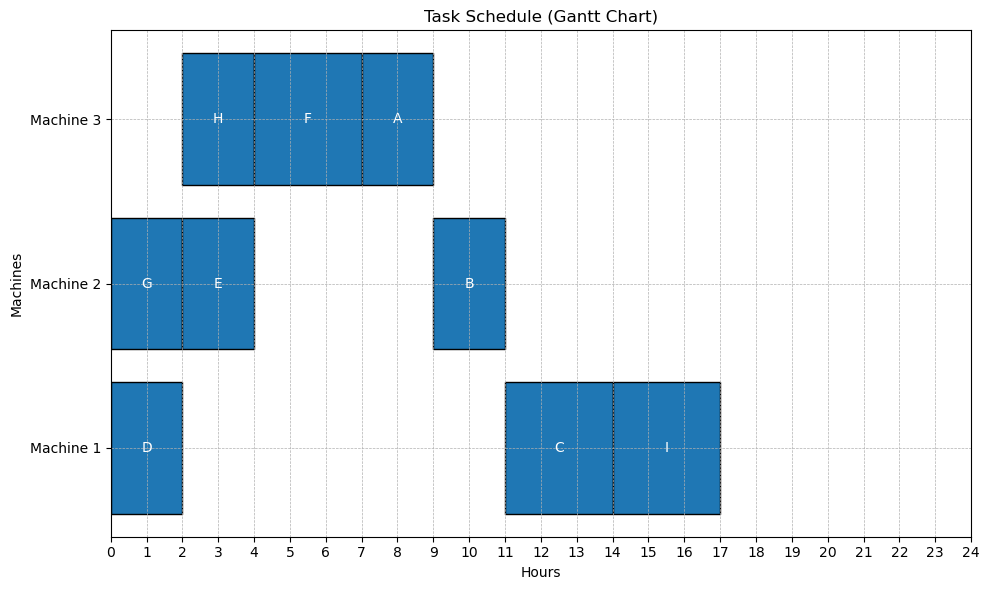

In [367]:

machine_next_available_time = {i+1: 0 for i in range(num_machines)} 
# Visualisation with Gantt Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Assign each machine a row on the chart
machine_rows = {machine_id: index + 1 for index, machine_id in enumerate(sorted(machine_next_available_time.keys()))}
for task_id, machine_id, start_time, end_time in task_timings:  
    ax.broken_barh([(start_time, end_time - start_time)], (machine_rows[machine_id] - 0.4, 0.8),
                   facecolors=('tab:blue'), edgecolor='black', label=task_id)
    ax.text((start_time + end_time) / 2, machine_rows[machine_id], task_id, ha='center', va='center', color='white')

# Setting the y-axis with machine labels
ax.set_yticks([machine_rows[machine_id] for machine_id in sorted(machine_rows.keys())])
ax.set_yticklabels([f'Machine {machine_id}' for machine_id in sorted(machine_rows.keys())])

# Formatting the x-axis to show time units clearly
plt.xlabel('Hours')
plt.ylabel('Machines')
plt.title('Task Schedule (Gantt Chart)')
ax.set_xticks(range(0, 25))  # This sets ticks from 0 to 24
ax.set_xticklabels(range(0, 25))  # This sets tick labels from 0 to 24
ax.set_xlim(0, 24)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

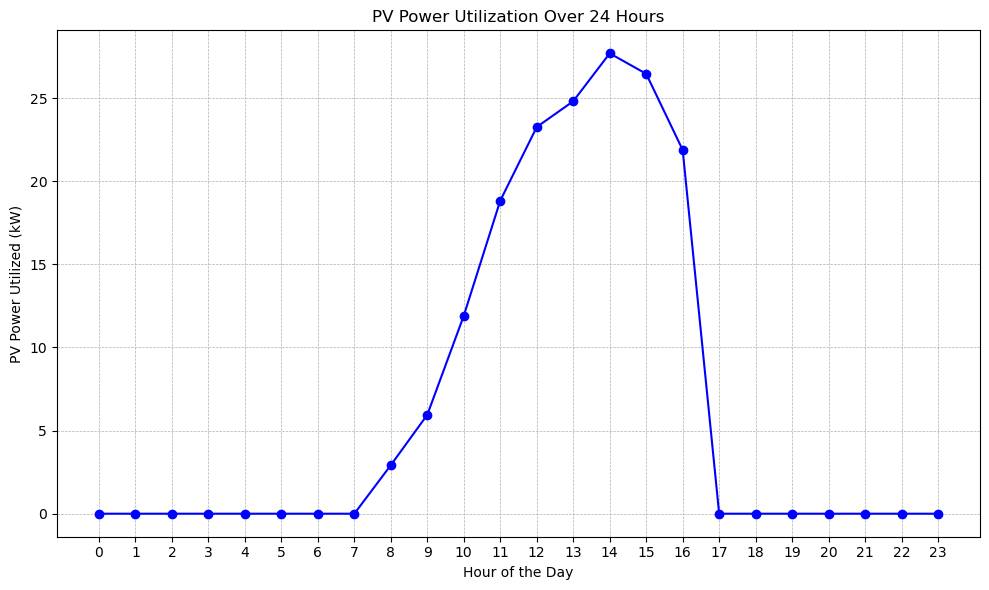

In [368]:
# Plotting the PV power used throughout the 24 hour period

plt.figure(figsize=(10, 6))
plt.plot(range(24), pv_power_utilized, marker='o', linestyle='-', color='blue')
plt.title('PV Power Utilization Over 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('PV Power Utilized (kW)')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [369]:
# Create a dataframe with the hour, energy from the grid, energy from the PV systems and the total energy from the grid + PV system

# First, create a list to hold the row data for the DataFrame
data_for_df = []

# Populate the data_for_df list with the required data
for hour in range(24):
    
    # Get the energy from grid for that hour
    energy_from_grid = grid_power_needed[hour]
    
    # Get the energy from PV for that hour
    energy_from_pv = pv_power_utilized[hour]
    
    # Calculate the total energy from grid + PV
    total_energy = energy_from_grid + energy_from_pv
    
    # Append the row to the list
    data_for_df.append({
        "Hour": hour,
        "Energy from Grid (kW)": energy_from_grid,
        "Energy from PV (kW)": energy_from_pv,
        "Total Energy (Grid+PV) (kW)": total_energy
    })

# Create the DataFrame
final_solution_df = pd.DataFrame(data_for_df).set_index('Hour')

# Display the DataFrame
final_solution_df


,Energy from Grid (kW),Energy from PV (kW),Total Energy (Grid+PV) (kW)
Hour,,,
0,46.000000,0.000000,46.0
1,46.000000,0.000000,46.0
2,68.000000,0.000000,68.0
3,68.000000,0.000000,68.0
4,37.000000,0.000000,37.0
5,37.000000,0.000000,37.0
6,37.000000,0.000000,37.0
7,35.000000,0.000000,35.0
8,32.079680,2.920320,35.0
